### Imports

In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import math

In [2]:
from skimage.color import rgb2gray

mittens = imread('./data/murder_mittens.png')

gray_mitts = rgb2gray(mittens)

# Generate 4 Layer Gaussian Pyramid

## Helper Functions

Some more details on the helper functions, `smooth` and `resize`.

`smooth` applies a simple Gaussian filter over the given image. This is used to compute $ G(m,n) = w(m)w(n) $ where $w(m) = [ 0.25 - 0.5a, 0.25, a, 0.25, 0.25 - 0.5a ]$. In-order to apply this 'a' notice that we had implemented the gaussian filter as:

(snippet)
```
    lw = int(truncate * sd + 0.5)
    weights = [0.0] * (2 * lw + 1)
    weights[lw] = 1.0
    sum = 1.0
    sd = sd * sd
    # calculate the kernel:
    for ii in range(1, lw + 1):
        tmp = math.exp(-0.5 * float(ii * ii) / sd)
        weights[lw + ii] = tmp
        weights[lw - ii] = tmp
        sum += 2.0 * tmp
    for ii in range(2 * lw + 1):
        weights[ii] /= sum

```

Thus, by using a $\sigma$ of 0.5, we get `int(4 * 0.5 + 0.5) = 2` which gets us `weights = [0.0] * (2 * 2 + 1)` which then gets filled as `weights = [0.05, 0.25, 0.4, 0.25, 0.05]` which is our intended $w(m)$. This is applied seperately row and column-wise using `correlated1d`.

`resize` applies a simple resizing operation that helps us sample half the bits in case scaling factor is less than 1, else it applies a Affine Transform to double the size and fill the alternating rows with 0. This is why we use `tform.params`. 

```
    tform.params[0, 1] = 0 # This tells us to fill alternated column with 0
    tform.params[1, 0] = 0 # This tells us to fill alternated row with 0
```

Thus a `(2,2)` image when stretched to `(4,4)` will look like:

```
            | a | 0 | b | 0 |
            ----------------
            | 0 | 0 | 0 | 0 |
 |a|b|      ----------------
 -----  --> | a | 0 | b | 0 |
 |a|b|      ----------------
            | 0 | 0 | 0 | 0 |

```

In [3]:
from scipy import ndimage as ndi
from skimage.transform._geometric import AffineTransform
from skimage.transform._warps import warp

def smooth(image, sigma):
    smoothed = np.empty(image.shape, dtype=np.double)
    ndi.gaussian_filter(image, sigma, output=smoothed)
    return smoothed


def resize(image, output_shape):
    output_shape = tuple(output_shape)
    input_shape = image.shape

    factors = (np.asarray(input_shape, dtype=float) /
               np.asarray(output_shape, dtype=float))

    rows = output_shape[0]
    cols = output_shape[1]
    input_rows = input_shape[0]
    input_cols = input_shape[1]
    if rows == 1 and cols == 1:
        tform = AffineTransform(translation=(input_cols / 2.0 - 0.5,
                                             input_rows / 2.0 - 0.5))
    else:
        
        
        # 3 control points necessary to estimate exact AffineTransform
        src_corners = np.array([[1, 1], [1, rows], [cols, rows]]) - 1
        dst_corners = np.zeros(src_corners.shape, dtype=np.double)
        
        
        # take into account that 0th pixel is at position (0.5, 0.5)
        dst_corners[:, 0] = factors[1] * (src_corners[:, 0] + 0.5) - 0.5
        dst_corners[:, 1] = factors[0] * (src_corners[:, 1] + 0.5) - 0.5

        tform = AffineTransform()
        tform.estimate(src_corners, dst_corners)

    # Parameters for accurate resizing
    tform.params[2] = (0, 0, 1)
    tform.params[0, 1] = 0
    tform.params[1, 0] = 0

    out = warp(image, tform, output_shape=output_shape)

    return out

## Pyramid Down function

This generates a downscaled image of the given image, which is also smoothed out.

In [4]:
def pyramid_down(image, downscale=2):
    image = img_as_float(image)

    out_shape = tuple([math.ceil(d / float(downscale)) for d in image.shape])

    sigma = 0.5

    smoothed = smooth(image, sigma)
    out = resize(smoothed, out_shape)

    return out

## Gaussian Pyramid

Generates the Gaussian Pyramid of a given image

In [5]:
def gaussian_pyramid(image, max_layer=-1, downscale=2):
    image = img_as_float(image)

    layer = 0
    current_shape = image.shape

    prev_layer_image = image
    yield image

    # build downsampled images until max_layer is reached or downscale process
    # does not change image size
    while layer != max_layer:
        layer += 1

        layer_image = pyramid_down(prev_layer_image, downscale)

        prev_shape = np.asarray(current_shape)
        prev_layer_image = layer_image
        current_shape = np.asarray(layer_image.shape)

        # no change to previous pyramid layer
        if np.all(current_shape == prev_shape):
            break

        yield layer_image

## Laplacian Pyramid

Generates the Laplacian Pyramid of the given image

In [6]:
def laplacian_pyramid(image, max_layer=-1, downscale=2):
    # cast to float for consistent data type in pyramid
    image = img_as_float(image)

    sigma = 0.5

    current_shape = image.shape

    smoothed_image = smooth(image, sigma)
    
    # Generate the first layer
    yield image - smoothed_image

    # build downsampled images until max_layer is reached or downscale process
    # does not change image size
    if max_layer == -1:
        max_layer = int(np.ceil(math.log(np.max(current_shape), downscale)))

    for layer in range(max_layer):

        out_shape = tuple(
            [math.ceil(d / float(downscale)) for d in current_shape])

        resized_image = resize(smoothed_image, out_shape)
        smoothed_image = smooth(resized_image, sigma)
        current_shape = np.asarray(resized_image.shape)

        yield resized_image - smoothed_image

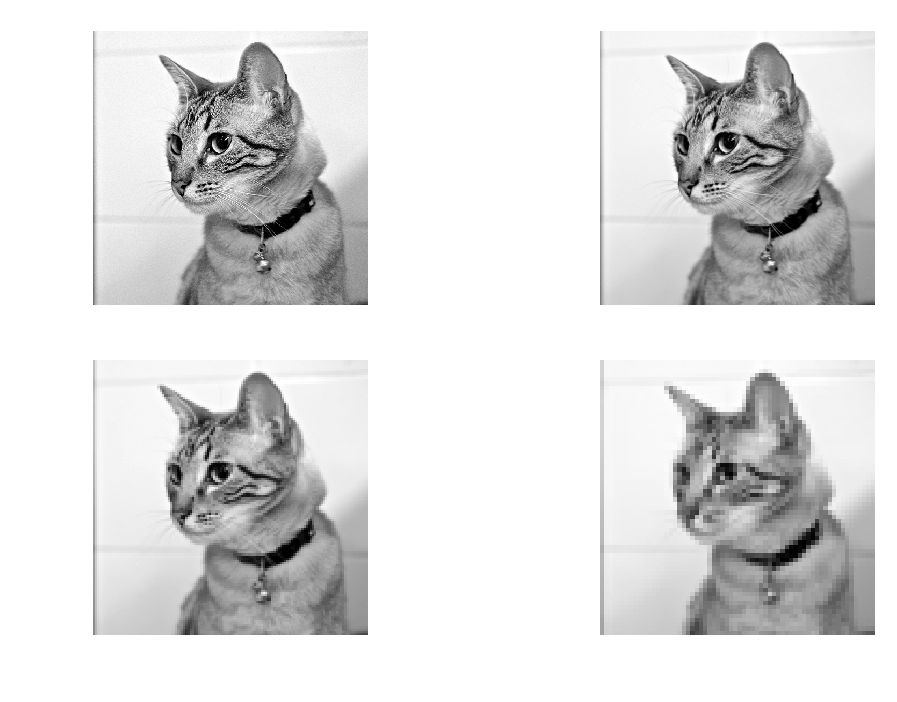

In [7]:
pyramid = tuple(gaussian_pyramid(gray_mitts, max_layer=3))

fig, axarr = plt.subplots(2, 2, dpi=200)

for i in range(4):
    axarr[i//2, i%2].axis('off')
    axarr[i//2, i%2].imshow(pyramid[i], cmap='gray')

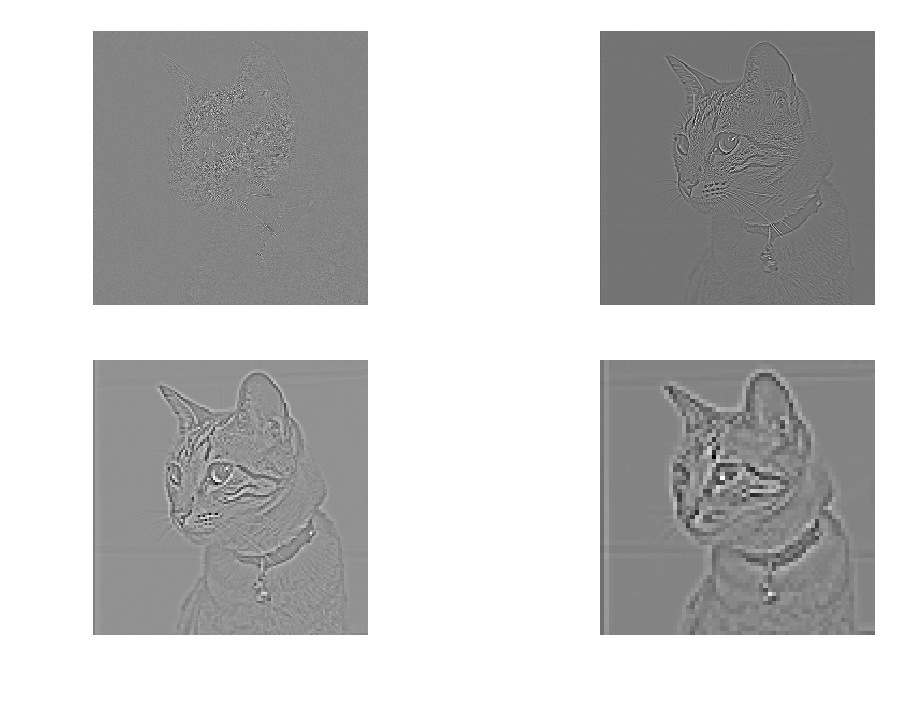

In [8]:
pyramid2 = tuple(laplacian_pyramid(gray_mitts, max_layer=3))

fig, axarr = plt.subplots(2, 2, dpi=200)

for i in range(4):
    axarr[i//2, i%2].axis('off')
    axarr[i//2, i%2].imshow(pyramid2[i], cmap='gray')

# Background Subtraction (single image)

In [9]:
from skimage import img_as_float
background = imread('./data/bg000.bmp')
woman = imread('./data/walk.bmp')

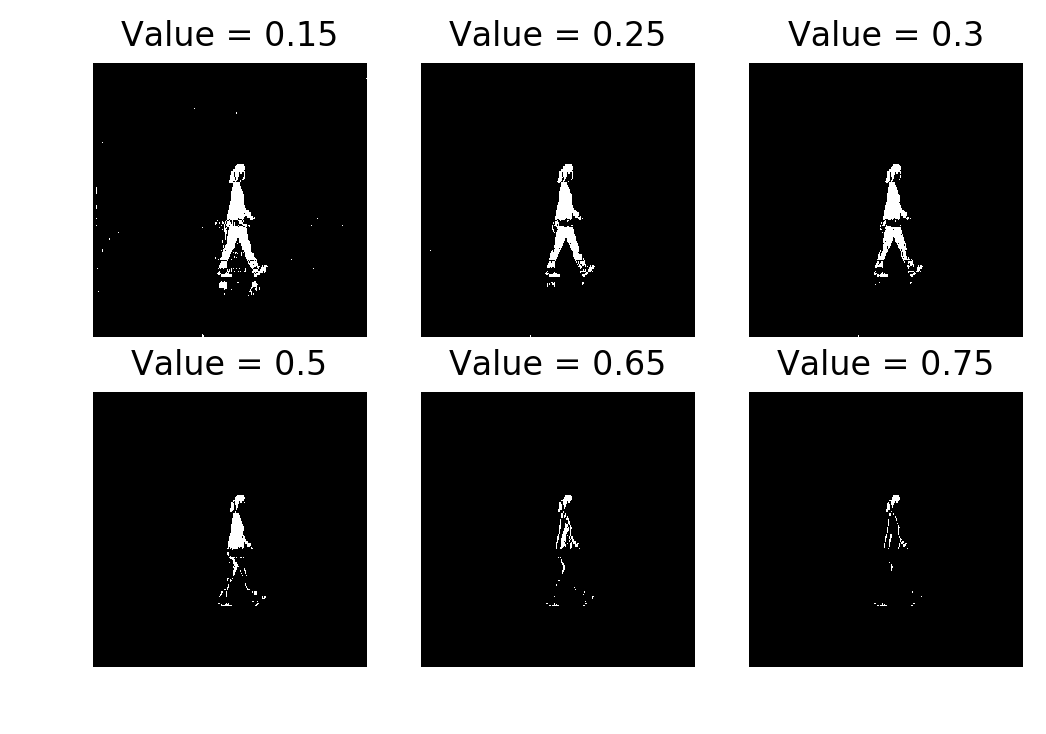

In [10]:
background = img_as_float(background)
woman = img_as_float(woman)

diff = np.abs(np.subtract(woman, background))

threshLevels = [0.15, 0.25, 0.3, 0.50, 0.65, 0.75]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    tImg = diff > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[idx // 3, idx%3].axis('off')
    axarr[idx // 3, idx%3].set_title(f'Value = {thresh}')
    axarr[idx // 3, idx%3].imshow(tImg, cmap = 'gray', aspect='auto')

From the above diagram, we can clearly observe that for threshold values `0.3 and 0.25` our naive subtraction does a pretty good job of identifying the woman from the background. However, notice that higher values like `0.75` and `0.15` do a bad job. Not only does the lower threshold introduce specs of activation all over the image, but also creates the overall body a lot "grainy", and higher threshold on the other hand are only able to capture small bits and pieces. If we were to post process these results with morphological operator, it may cause the person to dissappear completely, or the bounding box generated would be pretty bad.

# Background Subtraction (multiple images)

In [11]:
background_cube = []

for i in range(30):
    tmp = imread('./data/bg{:03}.bmp'.format(i))
    tmp = img_as_float(tmp)
    background_cube.append(tmp)

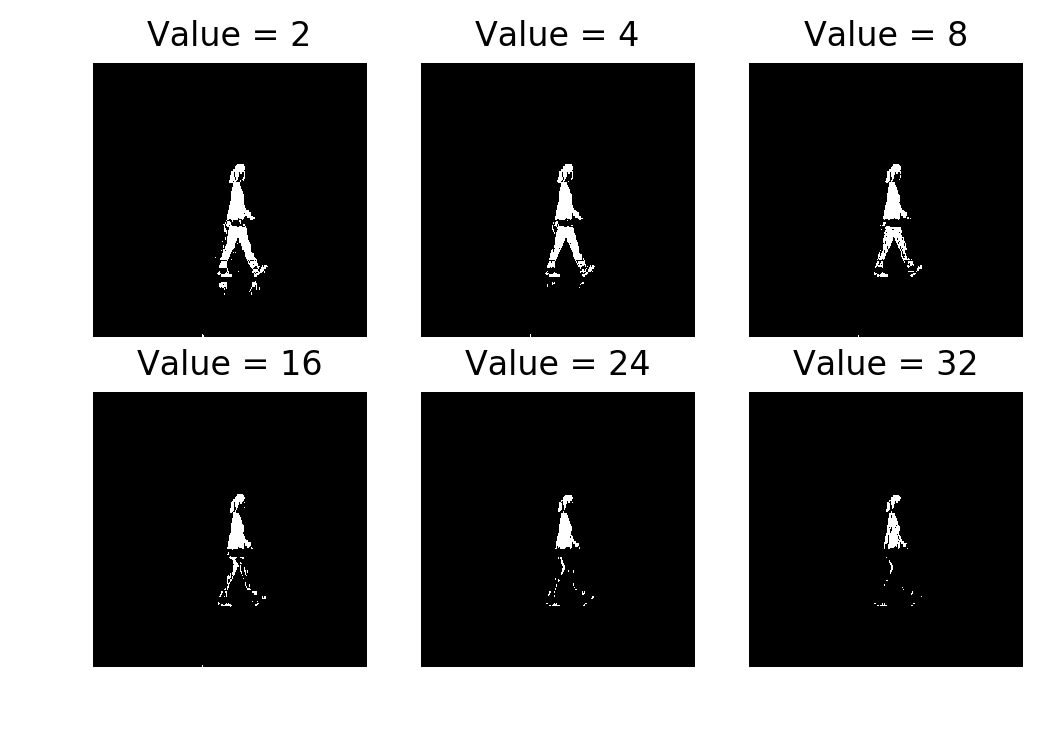

In [12]:
background_cube = np.array(background_cube)

background_mean = np.mean(background_cube, axis=0)

background_std = np.std(background_cube, axis=0) + 0.1

diff_mahalanobis = np.divide(np.square(np.subtract(woman, background_mean)), np.square(background_std))

threshLevels = [2, 4, 8, 16, 24, 32]
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for thresh in threshLevels:
    tImg = diff_mahalanobis > thresh
    idx = threshLevels.index(thresh)
    #print((int(idx/3), idx%3))
    axarr[idx // 3, idx%3].axis('off')
    axarr[idx // 3, idx%3].set_title(f'Value = {thresh}')
    axarr[idx // 3, idx%3].imshow(tImg, cmap = 'gray', aspect='auto')
    
thresh = diff_mahalanobis > 4

With our statistical model built upon a better understanding of what it looks like to be part of background, we notice that the person is detected pretty accurately. Also notice that this model is more tolerant to increased thresholds. Even at `T = 32` which covers more than 5 times the standard deviations, a level of significance so low that its barely used in most statistical analysis, we see that our thresholding holds up the upper body of the person relatively the same. This robustness I believe is completely worth the (minor) computation overhead that we incur.

# Dilate image

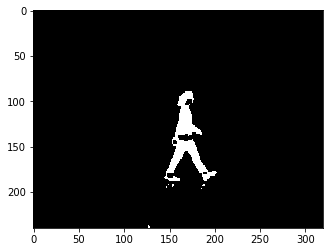

In [15]:
from skimage.morphology import closing
from skimage.morphology import square

plt.imshow(closing(thresh, square(3)), cmap='gray')


As expected that with a reasonable threshold, our dialated image generates a pretty neat "blob" of the person. Notice that the hip region is still broken, but this seems to be a quirk of the image, and not of the model that we have built

# Connected Components Algorithm

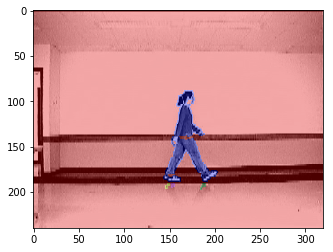

In [16]:
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

bw = dilation(thresh, square(3))

cleared = clear_border(bw)

label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=woman)

plt.imshow(image_label_overlay)

We can observe that our connected components algorithm does a pretty good job of identifying the person as a single component, (highlighted here in blue)